In [1]:
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1041: UserWarning: Duplicate key in file "/home/cloud-user/.config/matplotlib/stylelib/paper.mplstyle", line #9
  (fname, cnt))


In [2]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import seaborn as sns
from graph_tool import GraphView
from graph_tool.generation import lattice
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score
from collections import OrderedDict
from matplotlib import pyplot as plt

from helpers import infected_nodes, cascade_source
from graph_helpers import load_graph_by_name, remove_filters, get_edge_weights, extract_edges, extract_nodes
from random_steiner_tree.util import from_gt
from viz_helpers import lattice_node_pos
from sample_pool import TreeSamplePool
from tree_stat import TreeBasedStatistics
from experiment import gen_input
from root_sampler import build_true_root_sampler
from inference import infection_probability

from viz_helpers import visualize, default_plot_setting, tree_plot_setting

from cascade_generator import si


In [3]:
sampling_method = 'loop_erased'
obs_fraction = 0.4
cascade_fraction = 0.5
cascade_model = 'si'
fig_dirname = 'figs/intro'



In [5]:
g = lattice((6, 6))
ug = GraphView(g, directed=False)

n = int(np.sqrt(g.num_vertices()))
pos = lattice_node_pos(g, shape=(n, n))

g.set_directed(True)
g.add_edge_list([(int(e.target()), int(e.source())) for e in g.edges()])
    

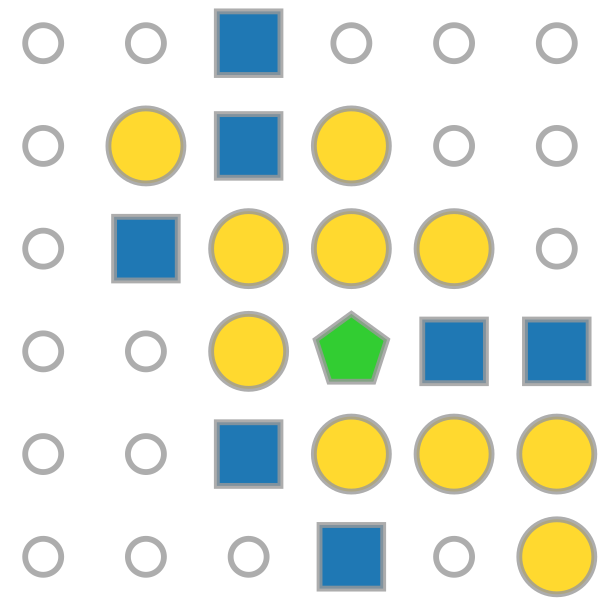

In [6]:
obs, c, true_tree = gen_input(g, source=21, stop_fraction=cascade_fraction, p=0.5, q=obs_fraction, return_tree=True)

inf_nodes = infected_nodes(c)
source = cascade_source(c)

node_size_mul = 6.0
edge_width_mul = 3.0

# plot cascade and observations

setting = default_plot_setting(ug, c, obs, size_multiplier=node_size_mul)
visualize(g, pos, **setting, output='{}/cascade.pdf'.format(fig_dirname))


In [7]:
gv = remove_filters(g)  # the reserved graph

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=100,
    method=sampling_method,
    gi=gi,
    return_type='tuples',
    with_resampling=False,
    with_inc_sampling=False)
sampler.fill(obs, root_sampler=build_true_root_sampler(c))

In [8]:
small_samples = list(sorted(sampler.samples, key=len))

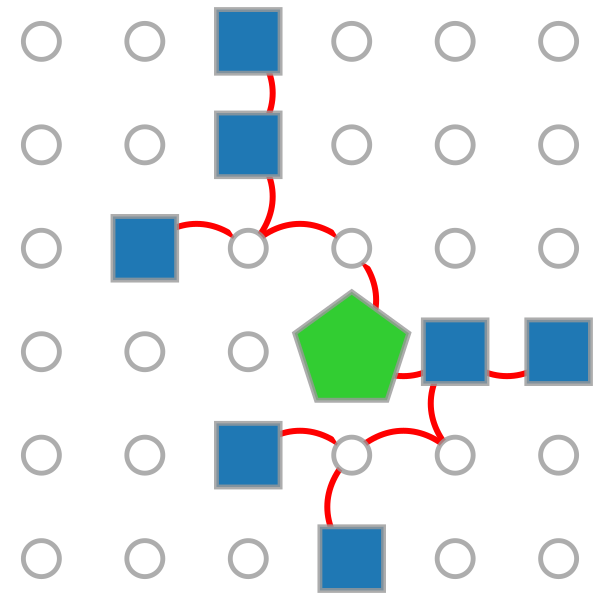

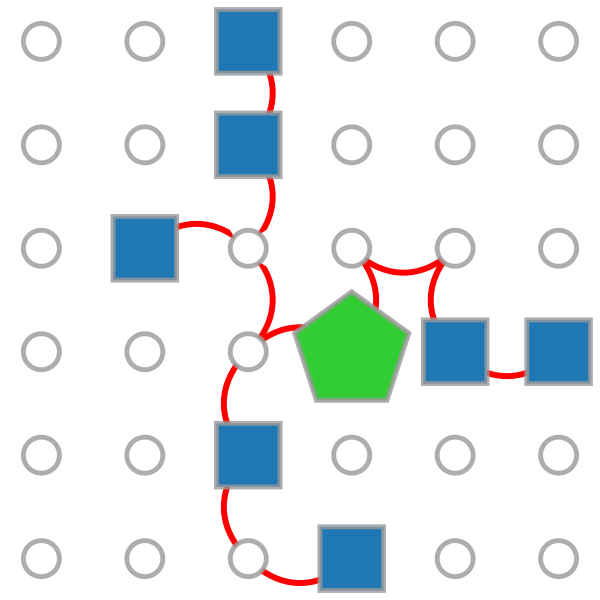

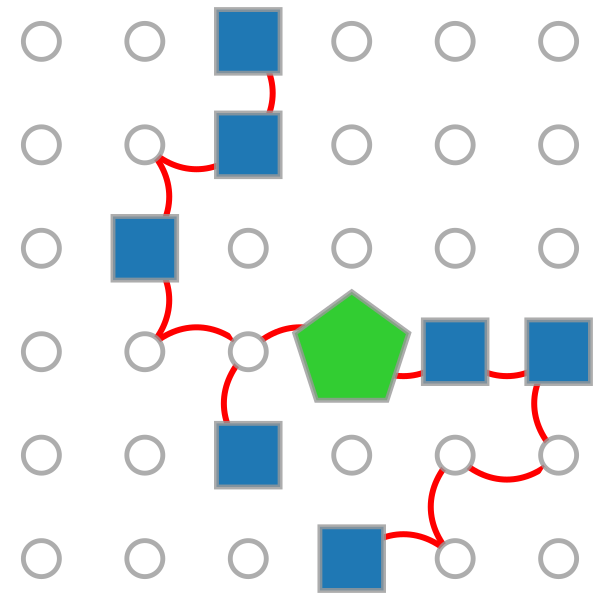

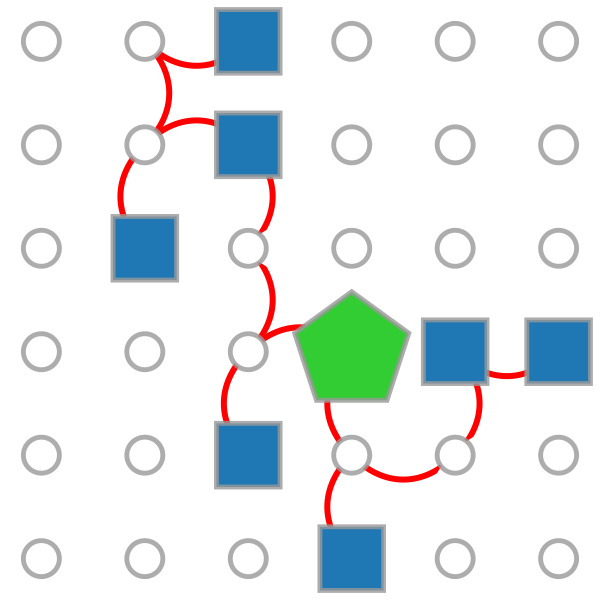

In [9]:
for i, tree in enumerate(small_samples[:4]):
    s = tree_plot_setting(ug, c, obs, tree,
                          size_multiplier=node_size_mul,
                          edge_width_multiplier=edge_width_mul,
                          deemphasize_hidden_infs=True)
    visualize(ug, pos, **s, output="{}/tree-{}.pdf".format(fig_dirname, i))

In [10]:
estimator = TreeBasedStatistics(gv)
probas = infection_probability(g, obs, sampler, estimator)

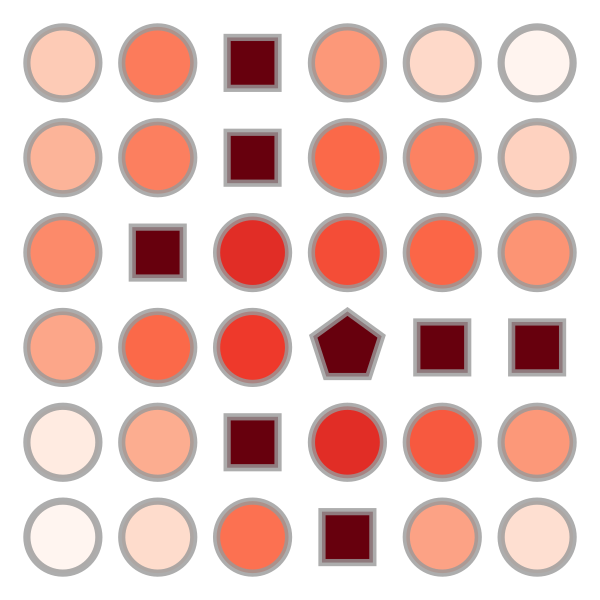

In [17]:
from viz_helpers import InfectionProbabilityViz

viz = InfectionProbabilityViz(g, pos)
hidden_infs = set(inf_nodes) - set(obs)
probas[obs] = 1.0
def f(s):
    # s['node_size_info'][tuple(hidden_infs)] = 20
    pass
viz.plot(
    c, obs, probas, setting_kwargs={'size_multiplier': node_size_mul * 1.2 },
    lighten_obs=False,
    output="{}/inf-probas.pdf".format(fig_dirname))

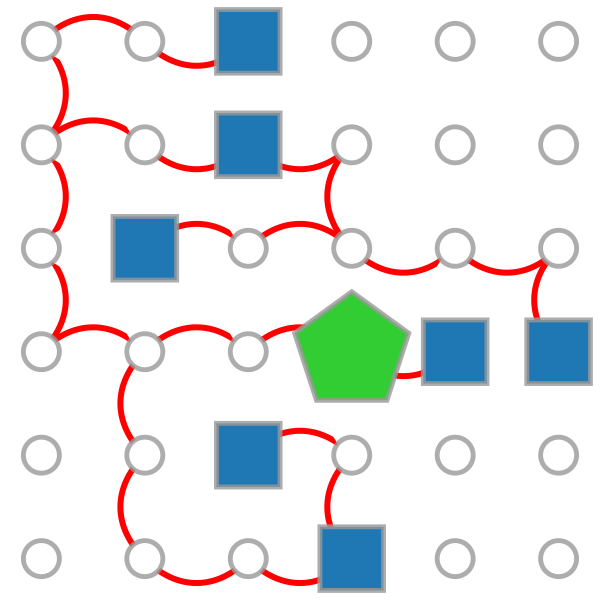

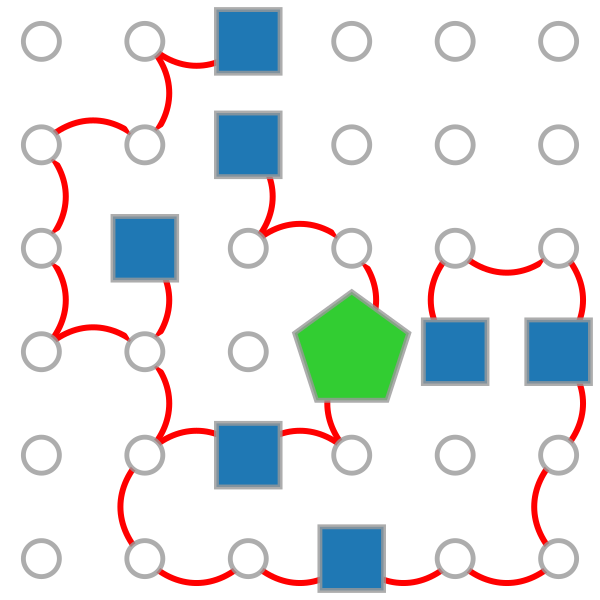

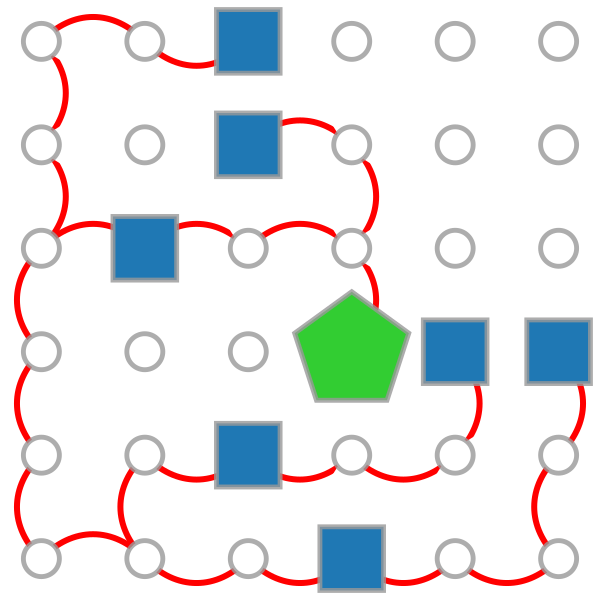

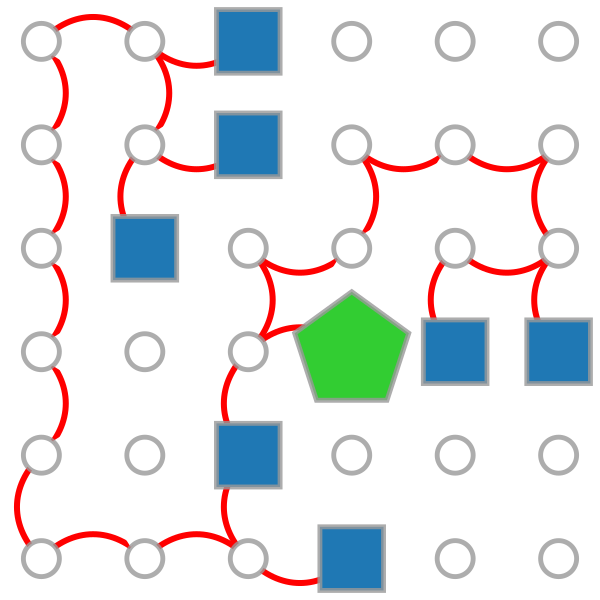

In [13]:
for i, tree in enumerate(small_samples[-4:]):
    s = tree_plot_setting(ug, c, obs, tree,
                          size_multiplier=node_size_mul,
                          edge_width_multiplier=edge_width_mul,
                          deemphasize_hidden_infs=True)
    visualize(ug, pos, **s, output="{}/big-tree-{}.pdf".format(fig_dirname, i))

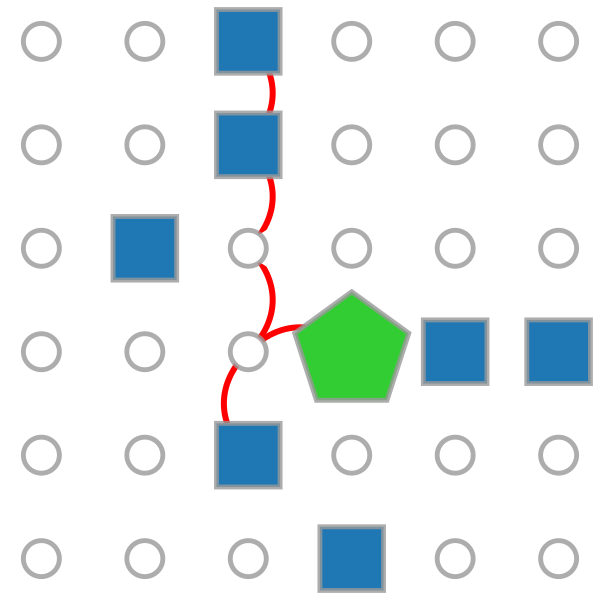

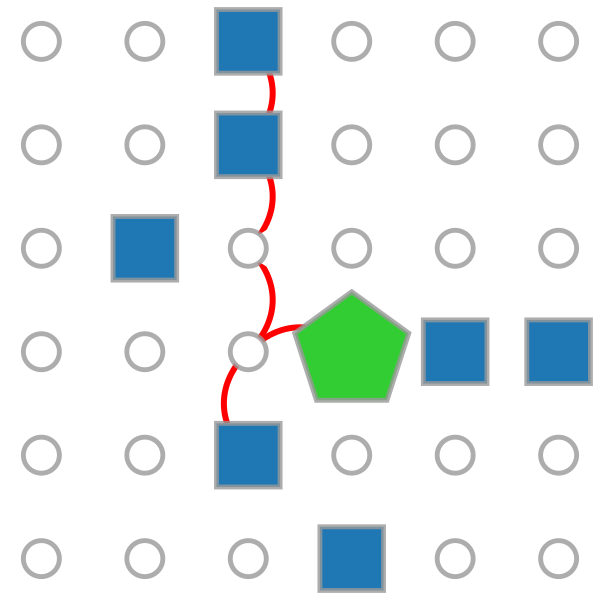

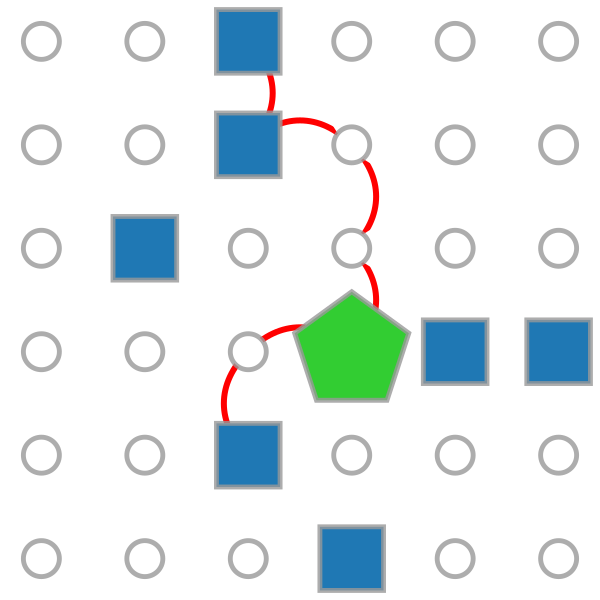

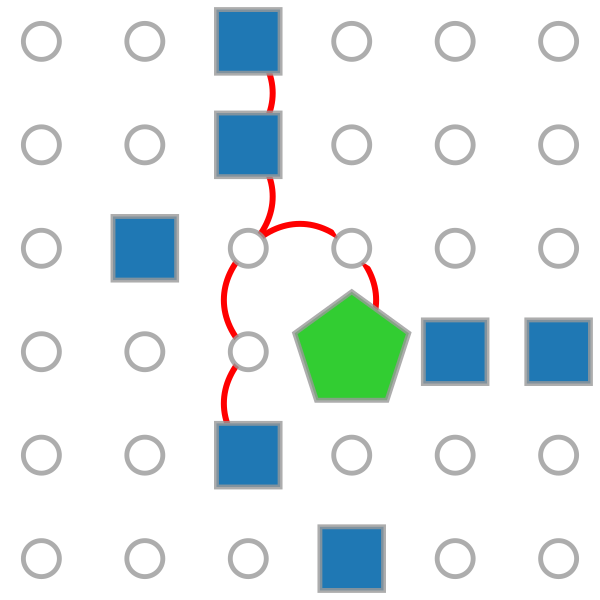

In [14]:
sampler.fill(obs[-3:], root_sampler=build_true_root_sampler(c))

bad_samples = sorted(sampler.samples, key=len)
for i, tree in enumerate(bad_samples[:4]):
    s = tree_plot_setting(ug, c, obs, tree,
                          size_multiplier=node_size_mul,
                          edge_width_multiplier=edge_width_mul,
                          deemphasize_hidden_infs=True)
    visualize(ug, pos, **s, output="{}/bad-tree-{}.pdf".format(fig_dirname, i))